# About the Dataset
<hr>

Welcome to this Kaggle notebook on kidney stones, a condition that affects millions of people worldwide.
Did you know that kidney stones are common with an estimated prevalence of **12%** in men and **6%** in women? These small mineral deposits can cause excruciating pain and significantly impact everyday life. Kidney stones account for over **500,000** emergency room visits in the United States alone! 



## Importing the required Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import warnings
warnings.filterwarnings('ignore', message=".*The 'nopython' keyword.*");
warnings.filterwarnings(action='ignore', category=DeprecationWarning);
warnings.filterwarnings(action='once')

In [5]:
! pip install umap-learn

In [6]:
# Ploting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
sns.set_style("darkgrid")

# Ploting high-dimesional data into 2D libraries
import umap;
from sklearn.manifold import TSNE;

# To deal with outliers
from scipy.stats.mstats import winsorize

# For data preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# For modelling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# For metrics and hyperparameter tuning
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, loguniform, randint

C:\Users\2211583\Anaconda3\envs\env_1\lib\threading.py:957: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  del self._target, self._args, self._kwargs
C:\Users\2211583\Anaconda3\envs\env_1\lib\threading.py:957: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  del self._target, self._args, self._kwargs
C:\Users\2211583\Anaconda3\envs\env_1\lib\threading.py:957: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  del self._target, self._args, self._kwargs


# 2. Loading Data

In [7]:
df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
# sub_df = pd.read_csv("../input/playground-series-s3e12/sample_submission.csv")

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x2085aa81840>
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()


In [9]:
display(df.head())
print(df.shape)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


(414, 8)


## 2.1 Data Charactersitics:
We shall now look at the number of missing values, unique values, duplicate value, datatype, min, max and few values.

In [12]:
def get_data_char(df):
    data_columns = df.columns
    data_char_df = pd.DataFrame(df.dtypes, columns = ["d_type"])
    data_char_df["#_missing"] = df.isna().sum()
    data_char_df["%_missing"] = (df.isna().sum() * 100) / df.shape[0]
    data_char_df["#_unique"] = df.nunique()
    data_char_df["%_unique"] = df.nunique() * 100 / df.shape[0]
    data_char_df["most_frequent"] = df.mode().loc[0]
    
   
    def get_stats_stats(df):
        return df.aggregate([min, max, "mean", "median", "std"]).T
    
    data_char_df = pd.concat([data_char_df,get_stats_stats(df), df.loc[:2,].T], axis = 1)    
    
    return data_char_df
display(get_data_char(df.iloc[:,1:]).style.background_gradient(subset = ["%_unique", "std", "median", "mean", "max", "min", "%_missing"], cmap = "Oranges"))

,d_type,#_missing,%_missing,#_unique,%_unique,most_frequent,min,max,mean,median,std,0,1,2
gravity,float64,0,0.000000,28,6.763285,1.021000,1.005000,1.040000,1.017894,1.018000,0.006675,1.013000,1.025000,1.009000
ph,float64,0,0.000000,71,17.149758,5.530000,4.760000,7.940000,5.955459,5.740000,0.642260,6.190000,5.400000,6.130000
osmo,int64,0,0.000000,80,19.323671,577.000000,187.000000,1236.000000,651.545894,679.500000,234.676567,443.000000,703.000000,371.000000
cond,float64,0,0.000000,65,15.700483,29.000000,5.100000,38.000000,21.437923,22.200000,7.514750,14.800000,23.600000,24.500000
urea,int64,0,0.000000,73,17.632850,159.000000,10.000000,620.000000,278.657005,277.000000,136.442249,124.000000,394.000000,159.000000
calc,float64,0,0.000000,85,20.531401,4.490000,0.170000,14.340000,4.114638,3.130000,3.217641,1.450000,4.180000,9.040000
target,int64,0,0.000000,2,0.483092,0.000000,0.000000,1.000000,0.444444,0.000000,0.497505,0.000000,0.000000,0.000000


#### Insights:
1. We have 6 independent variable, all of which are continous in nature, one identification variable (id) and one binary target variable.
2. The dataset has no missing values.
3. Most unique column is calc with just 20% unique data
3. The target varible has a mean < 0.5 and median of 0, indicating that the number of positive class (+1) examples are less than that of number of negative class examples (0)
4. The scales of the features vary a lot, the mean and std of gravity and osmo are on different scales (ones, hundreds). Scaling/Normalizing them is important.
5. The maximum and minimum values in the osmo, urea features vary a lot. Outliers may be present.
                                     

In [13]:
columns = df.columns[1:-1]
label = df.columns[-1]
print(columns)

df["target"] = df["target"].astype("category")

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], dtype='object')


# 3. EDA

In this section, we explore the traits and relationships among the features. We also draw a comparitive distribution among the train and test dataset.
We explore univarite, bivariate and finally multivariate relationships.

## 3.1 Univariate

<AxesSubplot: xlabel='target', ylabel='count'>

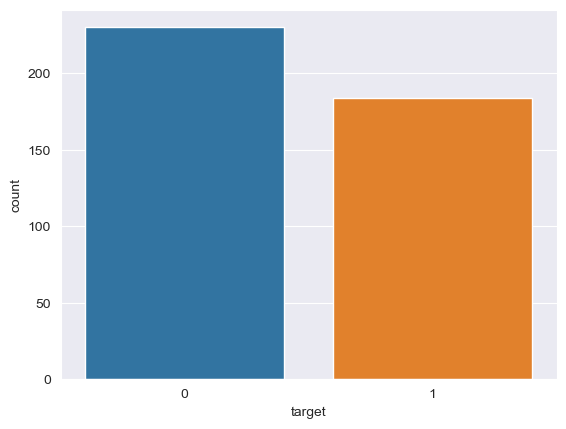

In [14]:
sns.countplot(x = df["target"])

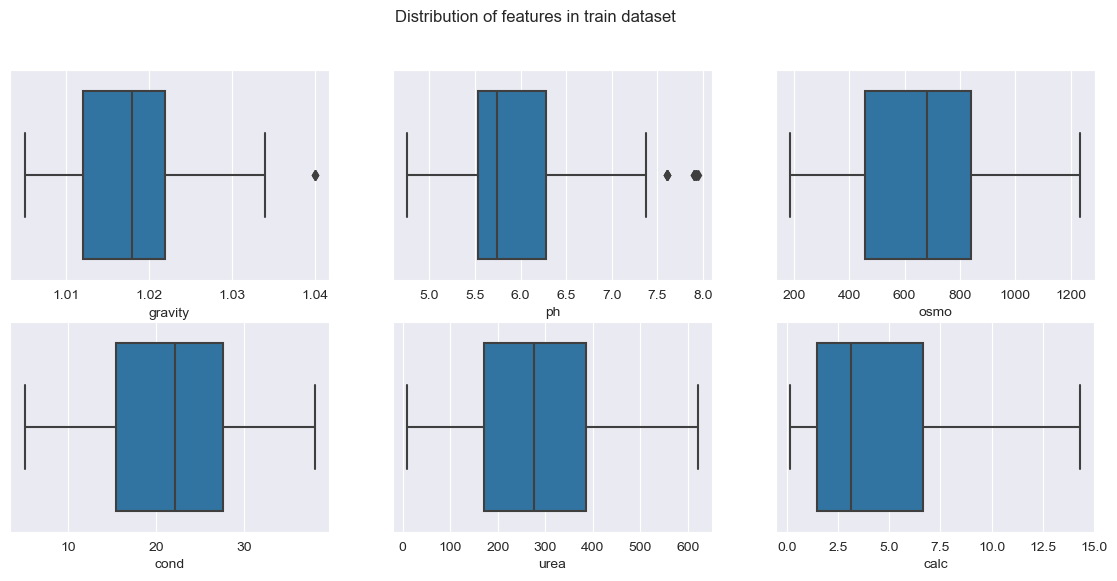

In [15]:
fig, axes = plt.subplots(2, 3, figsize = (14,6))
fig.suptitle('Distribution of features in train dataset')
for i in range(6):
    sns.boxplot(data = df, x = columns[i], ax = axes[i//3, i%3])
plt.show()

#### Insights:
There are outliers in the ph and gravity features. We will handle them in the data processing sections.

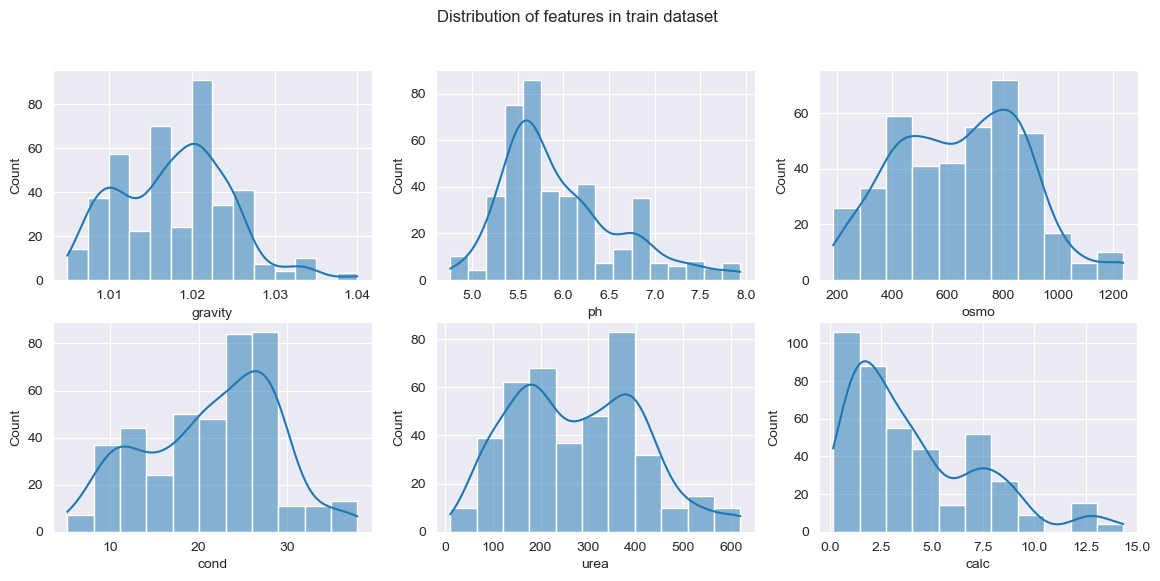

In [16]:
fig, axes = plt.subplots(2, 3, figsize = (14,6))
fig.suptitle('Distribution of features in train dataset')
for i in range(6):
    sns.histplot(data = df, x = columns[i], ax = axes[i//3, i%3], kde = True)
plt.show()

#### Insight:
All the features have a multi-modal distribution

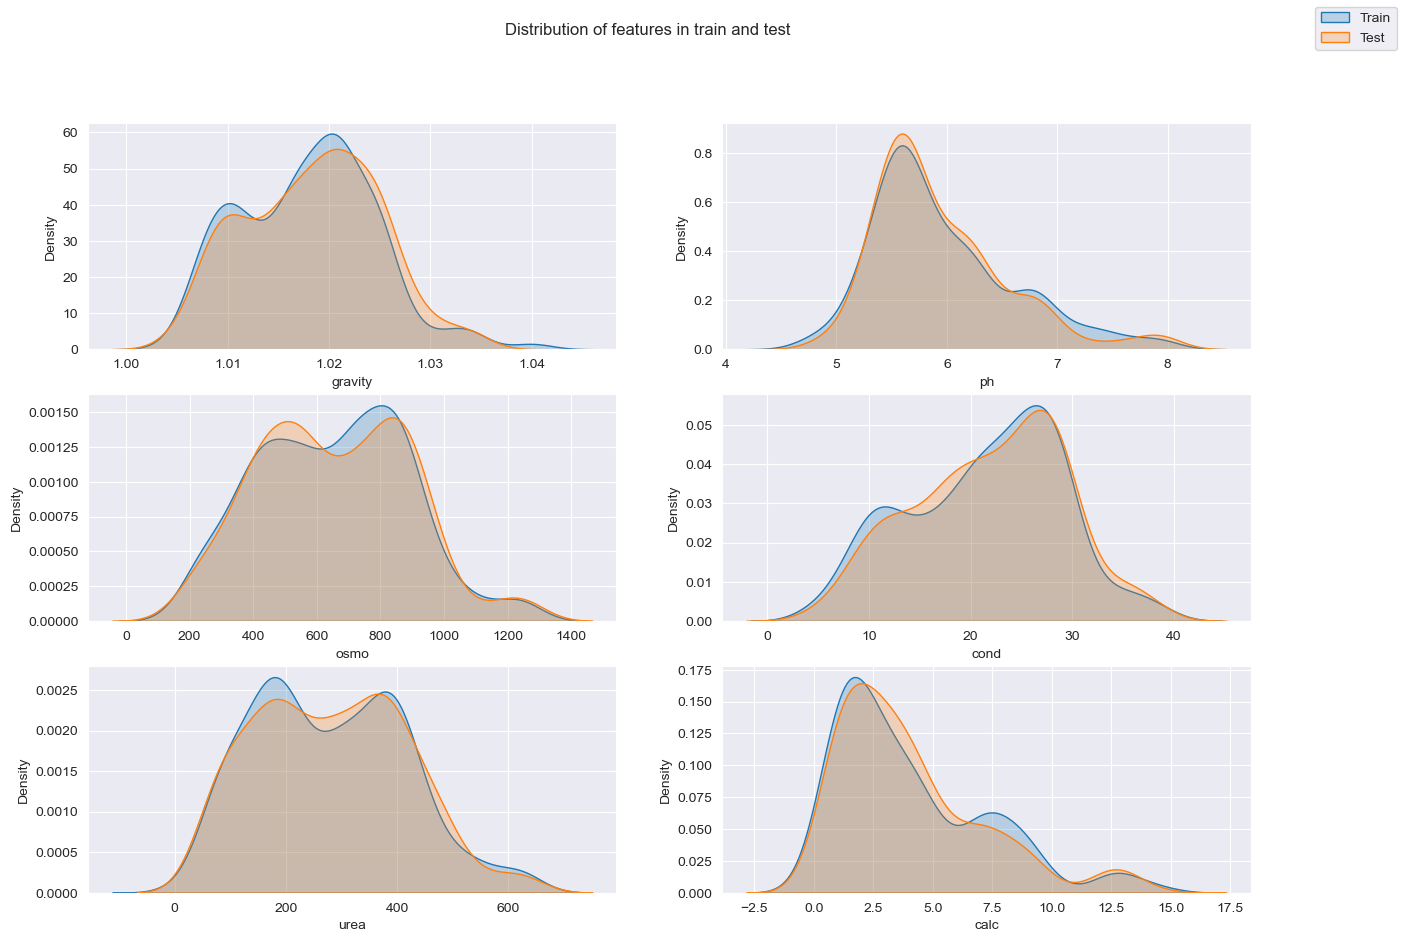

In [17]:
fig, axes = plt.subplots(3, 2, figsize = (15,10))
fig.suptitle('Distribution of features in train and test ')
for i in range(6):
    sns.kdeplot(df.iloc[:,i+1], ax = axes[i//2, i%2], fill = True)
    sns.kdeplot(test_df.iloc[:,i+1], ax = axes[i//2, i%2], fill = True)
fig.legend(labels=['Train','Test'])
plt.show()

#### Insights:
The distribution in the train and test dataset is nearly the same. That helps!

### 3.2 Bivariate

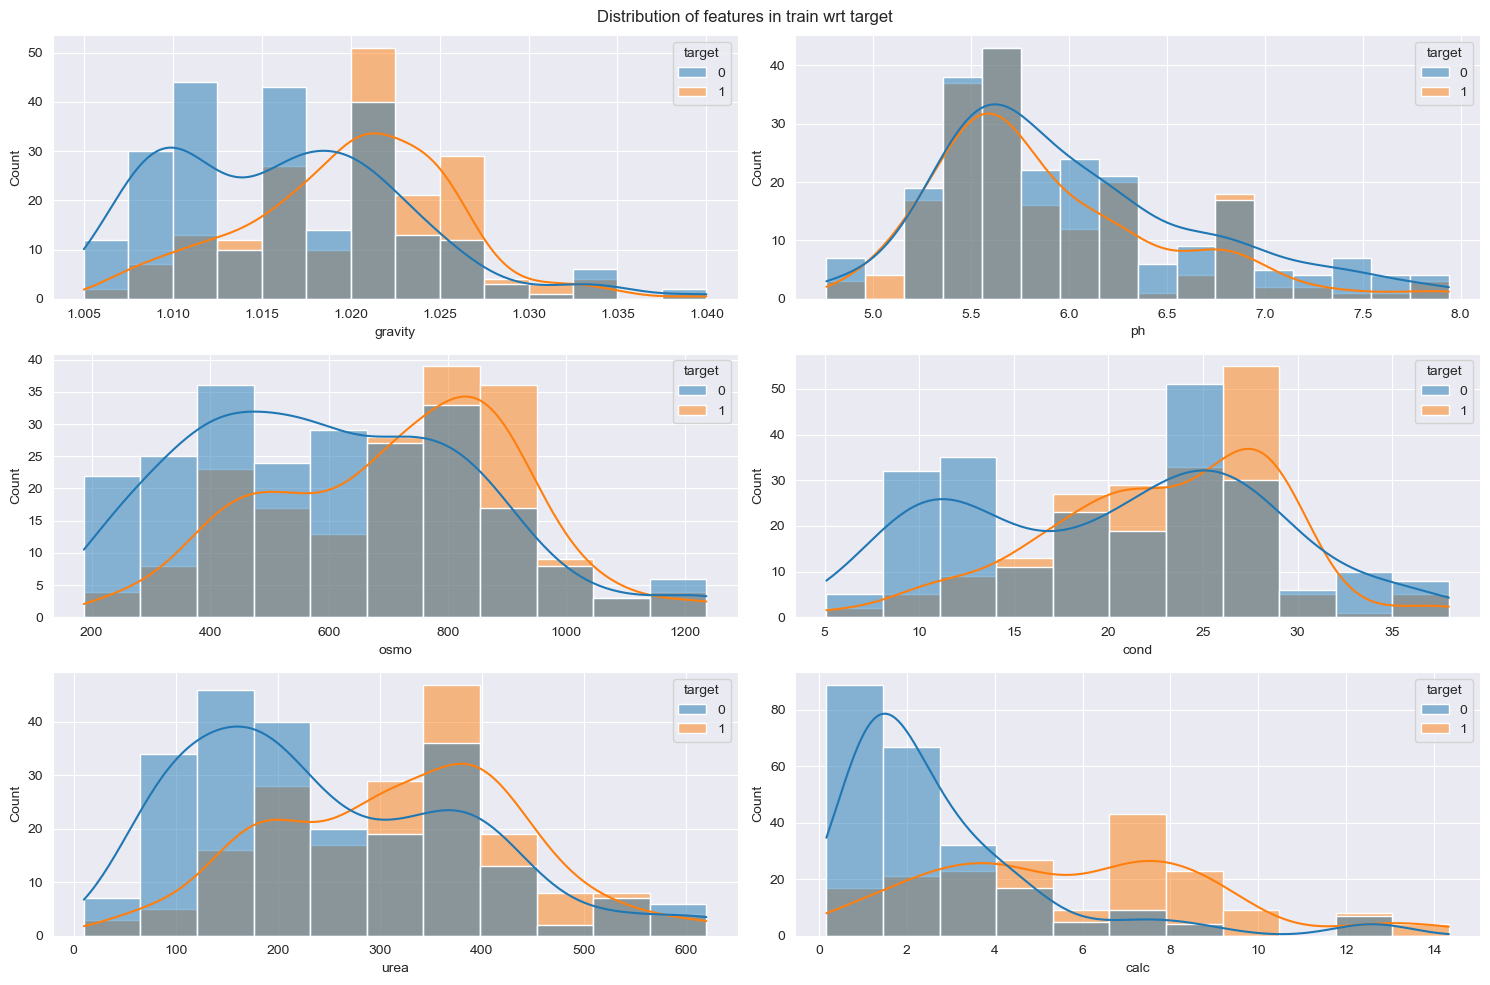

In [18]:
fig, axes = plt.subplots(3, 2, figsize = (15,10))
fig.suptitle('Distribution of features in train wrt target')
for i in range(6):
    sns.histplot(data = df, x = columns[i], hue = "target", ax = axes[i//2, i%2], kde = True)
fig.tight_layout()
plt.show()


#### Insight:
It appears, calc might also have some outliers. we will deal this later.

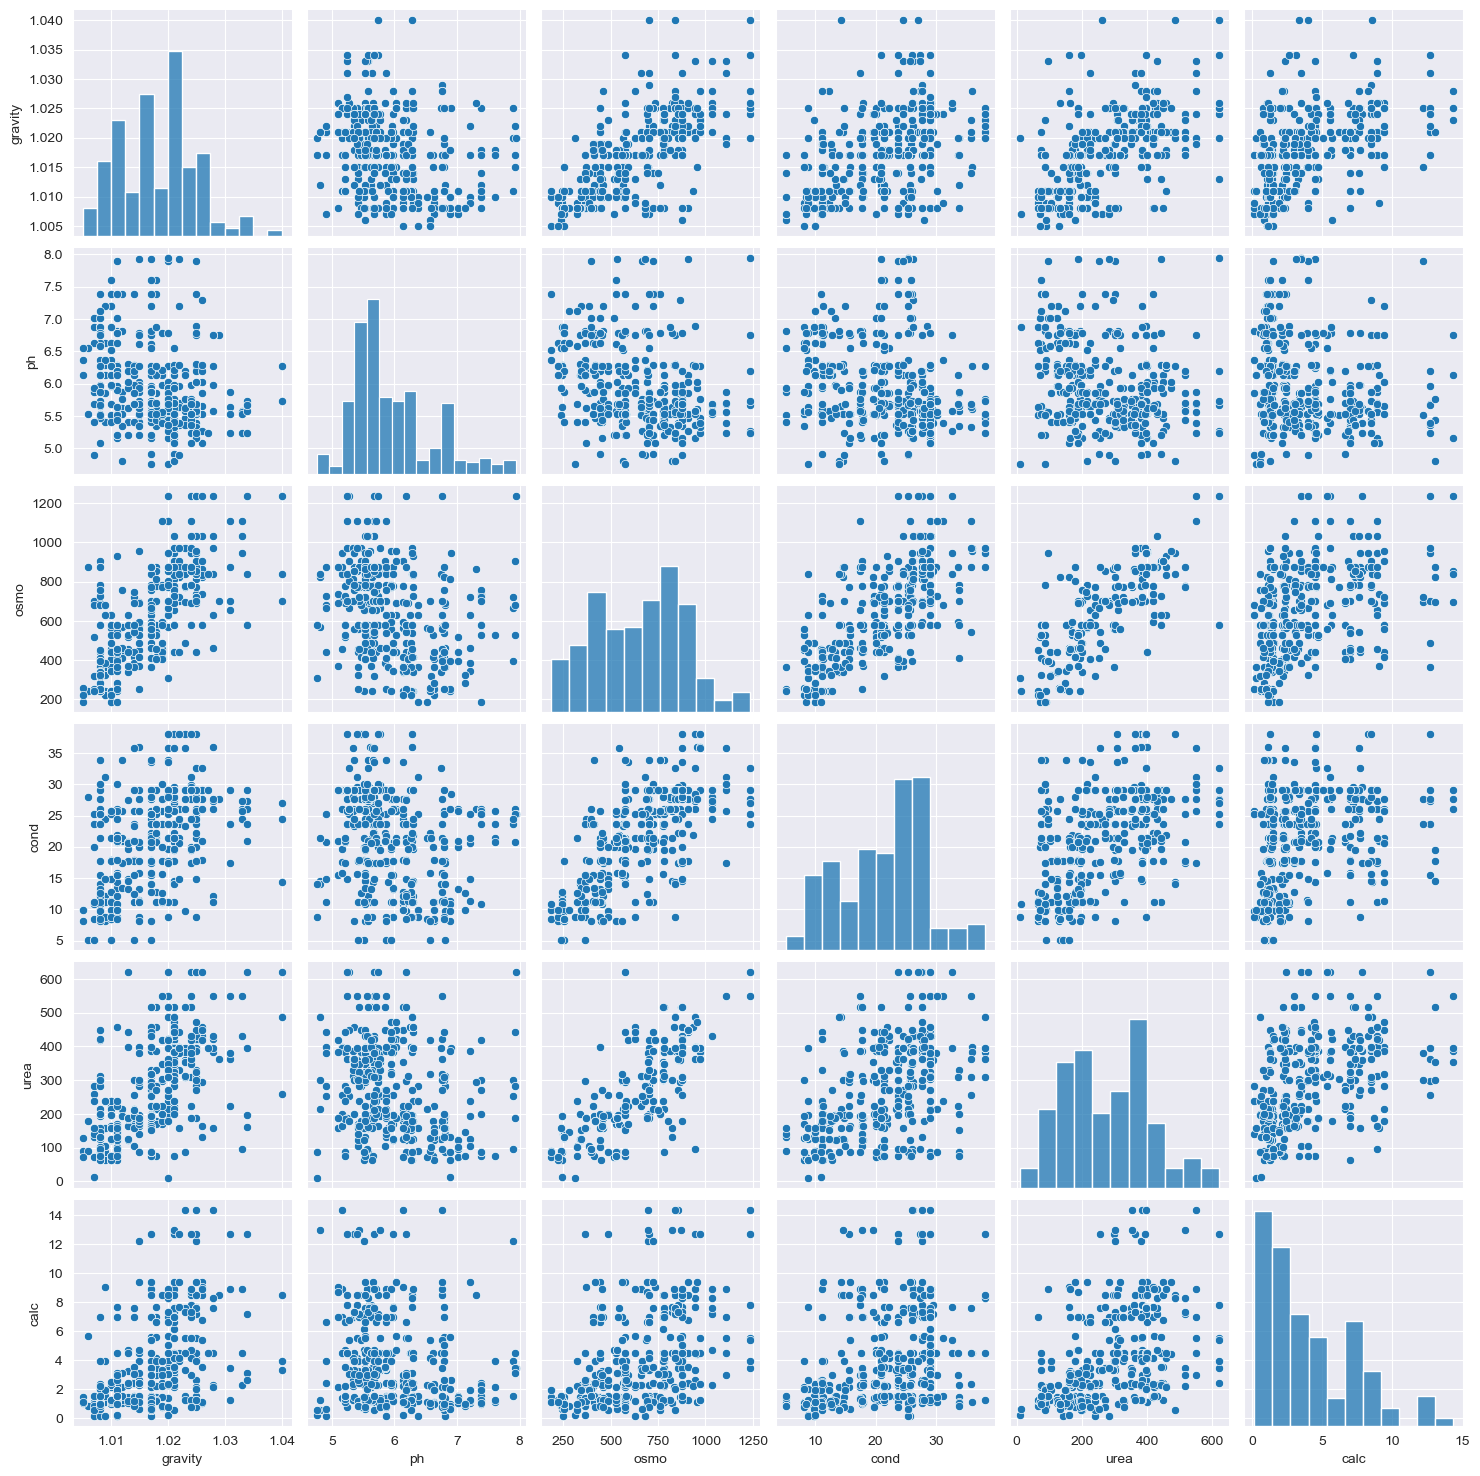

In [19]:
sns.pairplot(df[columns])

### 3.3 Multivariate 


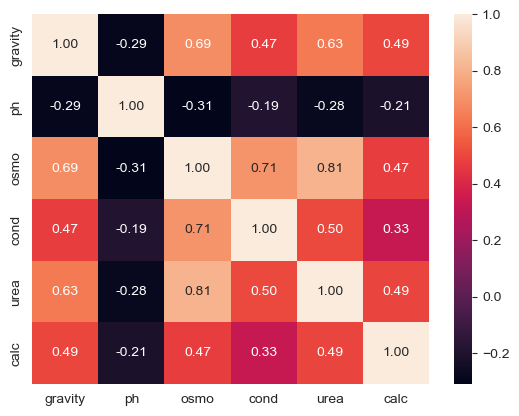

In [20]:
sns.heatmap(df[columns].corr(), annot = True, fmt = ".2f");

#### Insights

> 1. Gravity and osmolarity go hand in hand and thus should have extreme positive correlation.
> 2. osmolarity and conductivity also go parallely and should have positive correlation.
> 2. Urea and calcium should share a positive correlationship with gravity and osmolarity.
> 3. Acidic ph values should have positive relationship with urea and calcium []
> 4. As higher conductivity might result from other ions, calc might have weak/neither relationship

### 3.4 High Dimensional visualization - UMAP/T-SNE

C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\seaborn\_oldcore.py:917: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val in data
C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\pandas\core\arrays\categorical.py:197: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return getattr(np.array(self), opname)(np.array(other))
C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\pandas\core\ops\array_ops.py:273: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  res_values = op(lvalues, rvalues)
C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\seaborn\_oldcore.py:917: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val in data
C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\pandas\core\arrays\categorical.py:197: DeprecationWarning: elementwise comparison failed; this will raise an er

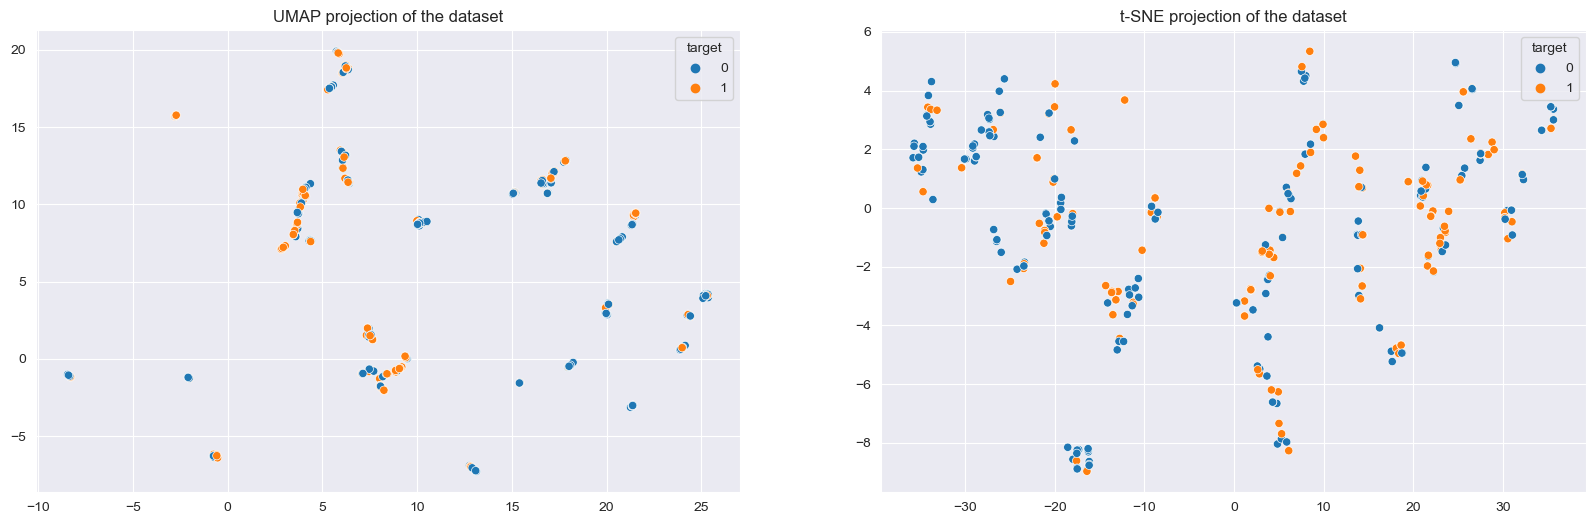

In [21]:
umap_data = umap.UMAP(n_components=2, random_state=42).fit_transform(df[columns])
tsne_data = TSNE(n_components=2, init='pca', random_state=42).fit_transform(df[columns])

fig, axes = plt.subplots(1, 2, figsize=(20,6), squeeze=False)

sns.scatterplot(umap_data, x=umap_data[:, 0], y=umap_data[:, 1], hue=df["target"], ax=axes[0,0])
axes[0,0].set_title("UMAP projection of the dataset")
sns.scatterplot(tsne_data, x=tsne_data[:, 0], y=tsne_data[:, 1], hue=df["target"], ax=axes[0,1])
axes[0,1].set_title("t-SNE projection of the dataset")

plt.show()

#### Insight:
The projection is difficult to interpret. But, there are a few sections in the above projections where the target variable is separable. 

# 4. Data Preprocessing

In this section, we deal with missing, duplicated, and outlier values. 
We would also scale the data, perform feature engineering and create X_train, X_test, y_train, y_test.

As we looked earlier, our dataset doesn't have missing and duplicated values. So we focus on dealing with outliers.

In [23]:
df_original = df.copy(deep = True)
df = df_original

X = df[columns].copy(deep = True)
y = df["target"].copy(deep = True)

### 4.1 Outlier - Using Winsorization - Shifting the outlier to 5th or 95th percentile value:

We identified in section 3.1, 3.3 that gravity ph and calc contain outlier.

In [24]:
outlier_columns = ["gravity", "ph", "calc"]
for col in outlier_columns:
    X.loc[:,col] = winsorize(X[col], (0.05, 0.05))

##### Plot them again and check:

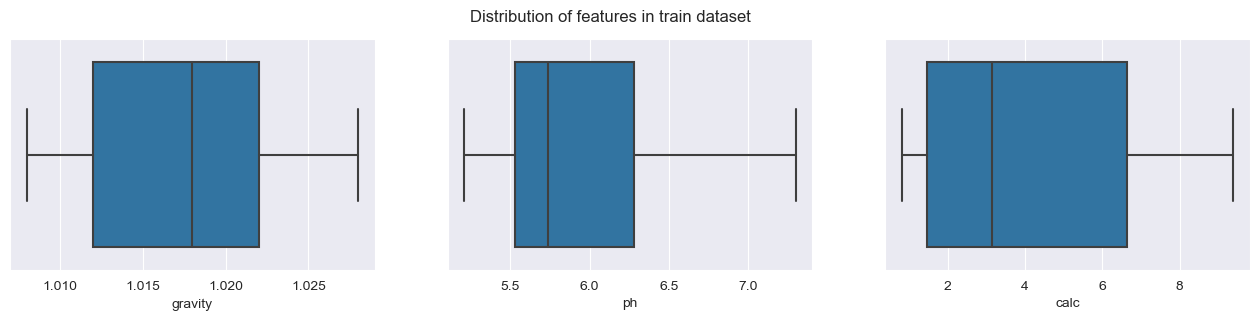

In [25]:
fig, axes = plt.subplots(1, 3, figsize = (16,3))
fig.suptitle('Distribution of features in train dataset')
for start, i in enumerate(outlier_columns):
    sns.boxplot(data = X, x = i, ax = axes[start%3])
plt.show()

In [26]:
# Dividing the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### 4.2 Feature scaling

In [27]:
scaler = StandardScaler()
# poly = PolynomialFeatures()

X_train = scaler.fit_transform(X_train)
# X_train = poly.fit_transform(X_train)

X_test = scaler.transform(X_test)
# X_test = poly.transform(X_test)

print(X_train.shape, X_test.shape)

(351, 6) (63, 6)


# 5. Modelling

In [28]:
def generate_models(name, estimator_obj, hyperparams):
    """Function to create dictionaries, 
    which will contain the model info and
    model hyperparamters."""
    return {
        "name" : name,
        "estimator" : estimator_obj,
        "hyperparameters" : hyperparams
    }

models = [
    generate_models("DummyClassifier", DummyClassifier(), 
                    {'strategy': ['most_frequent',"stratified"]}),
    generate_models("LogisticRegression",LogisticRegression(random_state=42),
                    {"C" : loguniform(1e-5,1),"penalty" : ["l1", "l2"],"solver": ['liblinear', 'saga'], "max_iter": randint(500,1250)}),
    generate_models("SVC", SVC(probability=True),
                   {"C" : loguniform(1e-5,1), "kernel" : ["linear", "rbf", "sigmoid", "poly"]}),
    generate_models("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42),
                    {"criterion":["gini", "entropy"], "max_depth": randint(3,10), "min_samples_split": randint(3,10), "min_samples_leaf": randint(3,10)}),
    generate_models("RandomForestClassifier", RandomForestClassifier(random_state=42), 
                    {"n_estimators":randint(100,250), "max_depth": randint(3,10), "criterion":["gini", "entropy"]}),
    generate_models("XGBClassifier", XGBClassifier(seed = 42, objective= 'binary:logistic', verbosity = 0,  eval_metric = 'auc'),
                    {'booster': ["gblinear", "gbtree"], "eta": loguniform(1e-4,1), "max_depth": randint(3,10), "min_samples_split": randint(3,10), "min_samples_leaf": randint(3,10)}),
    generate_models("CatBoostClassifier",CatBoostClassifier(random_seed = 42, loss_function= 'CrossEntropy',eval_metric = 'AUC', silent = True),
                   {'learning_rate': loguniform(1e-4,1e-1),"max_depth": randint(3,10), "iterations" : [300,500,750]}),
    generate_models("LightGBM", LGBMClassifier(random_state=42, ),
                   {'learning_rate': loguniform(1e-4,1e-1),"max_depth": randint(3,10), "n_estimators":randint(100,250), "num_leaves": randint(20,40), "min_child_samples": randint(10,30)})
    
]

**Note:** Here, **DummyClassifier** makes predictions that ignore the input features.This classifier serves as a simple baseline to compare against other more complex classifiers.

### 5.1 Set Baseline model:

To set a baseline model, we use the DummyClassifier model.

In [29]:
grid_search = GridSearchCV(estimator = models[0]["estimator"],param_grid = models[0]["hyperparameters"],scoring = "roc_auc", cv = 20)
grid_search.fit(X_train, y_train)
best_baseline = grid_search.best_estimator_
y_pred = best_baseline.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'BASELINE ROC AUC score: {roc_auc}')       
print("\033[1m--------------------------------------------------------\033[0m")

BASELINE ROC AUC score: 0.5
--------------------------------------------------------


### 5.2 Train models and Hyperparameter tuning

In [30]:
best_models = {}

for model in models[1:]:
    print(model["name"])
    
    # Performing the Grid Search for the parameter space.
    grid_search = RandomizedSearchCV(
        estimator = model["estimator"],
        param_distributions = model["hyperparameters"],
        scoring = "roc_auc",
        cv = 20, n_iter = 50, random_state= 42
    )
    grid_search.fit(X_train, y_train)
    
    # Saving the best paramters 
    best_model = grid_search.best_estimator_
    
    # Using the best paramters to predict the test data
    y_pred = best_model.predict(X_test)
    
    # Also, predicting the probabilities
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    acc_score = accuracy_score(y_test,y_pred)
    conf_mat = confusion_matrix(y_test,y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_predict_proba = roc_auc_score(y_test, y_pred_proba)
    
    
    print(f'Best hyperparameters: {grid_search.best_params_}')
    print(f'Accuracy: {acc_score}')
    print(f'ROC AUC score: {roc_auc}')
    print(f'ROC AUC PROBA: {roc_auc_predict_proba}')
    print(conf_mat)
    print("==" * 25)
    # Saving the model and its best hyperparamters in the dictionary
    best_models[model['name']] = best_model

LogisticRegression
Best hyperparameters: {'C': 0.49830438374949076, 'max_iter': 769, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.7936507936507936
ROC AUC score: 0.7878947368421052
ROC AUC PROBA: 0.8052631578947368
[[31  7]
 [ 6 19]]
SVC
Best hyperparameters: {'C': 0.14528246637516026, 'kernel': 'rbf'}
Accuracy: 0.7619047619047619
ROC AUC score: 0.7410526315789473
ROC AUC PROBA: 0.8242105263157895
[[32  6]
 [ 9 16]]
DecisionTreeClassifier
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 7}
Accuracy: 0.7936507936507936
ROC AUC score: 0.7878947368421052
ROC AUC PROBA: 0.8342105263157895
[[31  7]
 [ 6 19]]
RandomForestClassifier
Best hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 235}
Accuracy: 0.7936507936507936
ROC AUC score: 0.7947368421052632
ROC AUC PROBA: 0.8252631578947368
[[30  8]
 [ 5 20]]
XGBClassifier
Best hyperparameters: {'booster': 'gblinear', 'eta': 0.02801635158716258, 'max_depth': 4, 'min_

Every model delivers pretty same results.
On seeing the confusion matrices, we need to figure out if the models are failing on different examples, if yes, then we can leverage ensemble techniques to get the best model.

In [31]:
best_models

{'LogisticRegression': LogisticRegression(C=0.49830438374949076, max_iter=769, penalty='l1',
                    random_state=42, solver='saga'),
 'SVC': SVC(C=0.14528246637516026, probability=True),
 'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                        min_samples_split=7, random_state=42),
 'RandomForestClassifier': RandomForestClassifier(max_depth=3, n_estimators=235, random_state=42),
 'XGBClassifier': XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eta=0.02801635158716258,
               eval_metric='auc', feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max

# 6. Error Analysis

In this section, we will explore the failed test examples and explore if there's any pattern in them. This will help us to know the limitations of our models. 

### 6.1 Find bottleneck examples

In [34]:
def test_case_failed(model, y_true = y_test, X_test = X_test):
    """To get the list of all the indexes where model prediction was wrong"""
    y_pred_model = model.predict(X_test)
    return y_test.iloc[np.where(y_true != y_pred_model)[0]].index.to_list()
    
test_case_failed(best_models["XGBClassifier"])

[373, 140, 55, 84, 402, 94, 104, 290, 15, 271, 73, 77, 155]

In [35]:
# This variable will store the indexes of all the predictions which were wrong
df_failed_cases = {}
# This variable will will store the unique indexes which were not classified correctly by all the models.
all_bottleneck_cases = set()
for model,estimator in best_models.items():
    failed_cases = test_case_failed(estimator)
    df_failed_cases[model] = failed_cases
    all_bottleneck_cases = all_bottleneck_cases.union(set(failed_cases))  

all_bottleneck_cases = list(all_bottleneck_cases)    
print("y_true:", y.iloc[all_bottleneck_cases].to_list())
print("All bottleneck cases:", all_bottleneck_cases)
print("Total bottleneck examples:", len(all_bottleneck_cases))

y_true: [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
All bottleneck cases: [72, 73, 9, 140, 77, 15, 271, 399, 402, 275, 84, 155, 94, 290, 355, 104, 373, 55, 184]
Total bottleneck examples: 19


### 6.2 Visualize examples
Visualizing records for only those which were wrongly classified. So as to observe any pattern.

C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\seaborn\_oldcore.py:917: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val in data
C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\pandas\core\arrays\categorical.py:197: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return getattr(np.array(self), opname)(np.array(other))
C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\pandas\core\ops\array_ops.py:273: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  res_values = op(lvalues, rvalues)
C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\seaborn\_oldcore.py:917: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val in data
C:\Users\2211583\Anaconda3\envs\env_1\lib\site-packages\pandas\core\arrays\categorical.py:197: DeprecationWarning: elementwise comparison failed; this will raise an er

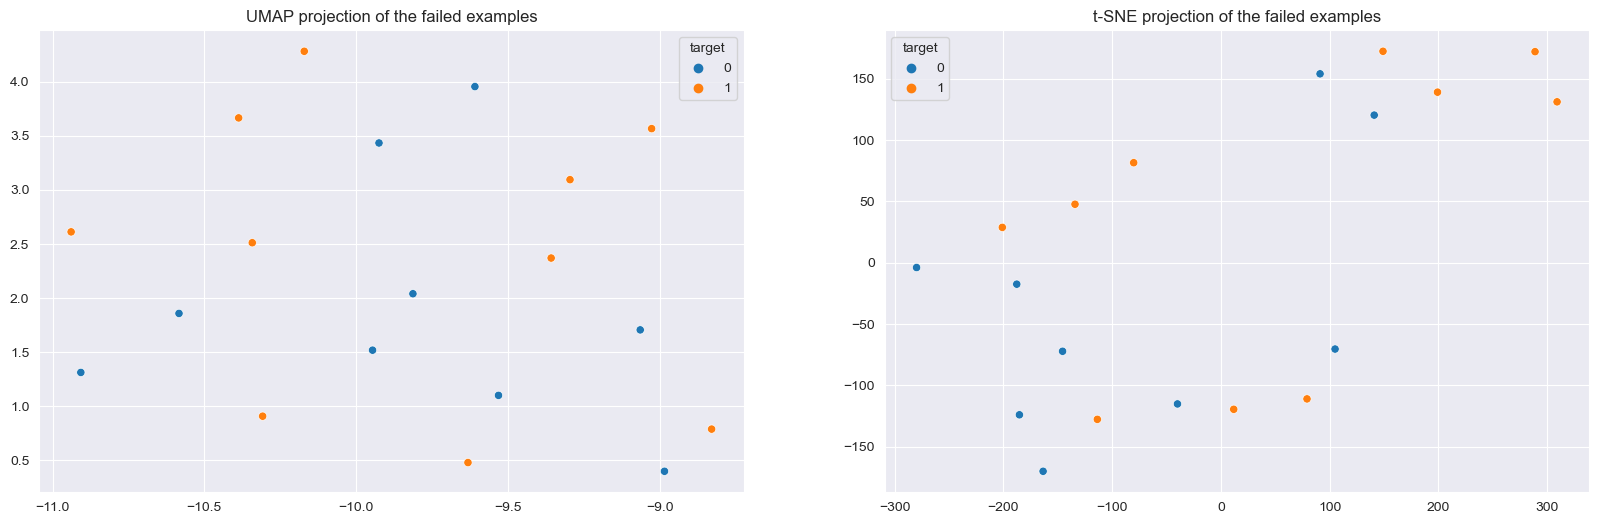

In [36]:
hue = y.iloc[all_bottleneck_cases]

umap_data = umap.UMAP(n_components=2, random_state=42).fit_transform(X.iloc[all_bottleneck_cases])
tsne_data = TSNE(n_components=2, perplexity= 5, init='pca', random_state=42).fit_transform(X.iloc[all_bottleneck_cases])

fig, axes = plt.subplots(1, 2, figsize=(20,6), squeeze=False)

sns.scatterplot(umap_data, x=umap_data[:, 0], y=umap_data[:, 1], hue=hue, ax=axes[0,0])
axes[0,0].set_title("UMAP projection of the failed examples")
sns.scatterplot(tsne_data, x=tsne_data[:, 0], y=tsne_data[:, 1], hue=hue, ax=axes[0,1])
axes[0,1].set_title("t-SNE projection of the failed examples")

plt.show()

Not much help.

### 6.3 Tabular evaluation of all the models
Will provide insights if generating an ensemble is a better option

In [37]:
from collections import defaultdict

# For applying color to the data frame
def color_boolean(val):
    color =''
    if val == True:
        color = '#FFCCCB'
    elif val == False:
        color = '#90EE90'
    return 'background-color: %s' % color

analyze_dict = defaultdict(list)
# This loops just checks whether among the records which were miss-classified, were they missclassified by the individual model.
for case in sorted(all_bottleneck_cases):
    for model, failed_cases in df_failed_cases.items():
        if case in failed_cases:
            analyze_dict[case].append(True)
        else:
            analyze_dict[case].append(False)
        
# pd.DataFrame(analyze_dict, index = list(df_failed_cases.keys())).style.applymap(color_boolean)
# Creating a dataframe for the above created dictionary "analyze_dict"
df_analyze = pd.DataFrame(analyze_dict, index = list(df_failed_cases.keys()))
# Calcualting the number of errors by the model
correct_predictions = len(all_bottleneck_cases) - df_analyze.sum(axis = 1)  
# Ratio of the wrong predictions
ratio_of_correct_predictions = correct_predictions / len(all_bottleneck_cases)
df_analyze.insert(loc = 0, column= "correct_predictions", value=correct_predictions)
df_analyze.insert(loc = 1, column= "ratio_of_correct_predictions", value=ratio_of_correct_predictions)
# For adding the color
df_analyze.style.applymap(color_boolean).background_gradient(subset = ["correct_predictions","ratio_of_correct_predictions"], cmap = "Oranges")


,correct_predictions,ratio_of_correct_predictions,9,15,55,72,73,77,84,94,104,140,155,184,271,275,290,355,373,399,402
LogisticRegression,6,0.315789,False,True,True,False,True,True,True,True,True,True,True,False,True,False,True,False,True,False,True
SVC,4,0.210526,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,False,True,False,True
DecisionTreeClassifier,6,0.315789,False,True,True,False,True,True,True,True,False,True,True,False,True,False,True,True,True,False,True
RandomForestClassifier,6,0.315789,False,True,True,False,True,True,True,True,False,True,True,False,True,True,True,True,False,False,True
XGBClassifier,6,0.315789,False,True,True,False,True,True,True,True,True,True,True,False,True,False,True,False,True,False,True
CatBoostClassifier,5,0.263158,False,True,True,False,True,True,True,True,True,True,True,False,True,False,True,True,True,False,True
LightGBM,5,0.263158,True,True,True,False,True,False,True,True,False,True,False,True,True,False,True,True,True,True,True


How to interpret: <br>
True indicates that test case index number 72 was predicted incorrectly by SVC but other models predicted it correctly. Whereas a false for test case 77 would mean, only LightGBM was correctly able to interpret it.

Yes, creating a ensemble model with soft voting will surely be an improve our AUC_ROC scores